In [1]:
import sys
import os
import time
import random
import json
from datetime import timezone, datetime
import string
import uuid
from uuid import UUID
import pandas as pd
import seaborn as sns
#%pylab inline

In [2]:
def random_generator(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for x in range(size))

def random_hexgenerator():
    hexN="0x"+uuid.uuid4().hex
    return hexN[:18]
def timestamp_gen():
    ts=int(datetime.now(tz=timezone.utc).timestamp() * 1000)
    return ts

class UUIDEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, UUID):
            # if the obj is uuid, we simply return the value of uuid
            return obj.hex
        return json.JSONEncoder.default(self, obj)

In [17]:
from cassandra.cluster import Cluster
cluster = Cluster()

cluster = Cluster()
connection=cluster.connect('perf')
#session = cluster.connect()

write_readings={}
 
documents_number = 20000 * 200000
j=0
itr=0
MAX_ITR=10
total_docs=0

In [18]:
prepared = connection.prepare('INSERT INTO perf.cassandra_test1 JSON ?')
#start = datetime.now();
startf = datetime.now();
while itr<MAX_ITR: 
    start = datetime.now();
    for index in range(documents_number):
        
        try:
            u=str(uuid.uuid1())
            value = random.randint(1,90000)
            syscall_nr=random_generator(4,'12345')
            syscall_name=random_generator(6,"abcdefghijklmnopqrstuvwxyz")
            dtb=random_hexgenerator()
            rsp=random_hexgenerator()
            rip=random_hexgenerator()
            pid=random.randint(1,10000)
            vmid="vm"+random_generator(2,'1234')
            logtype=random_generator(3,'xyz')
            
            obj={'id':u,
                 'dtb':dtb,
                 'logtype':logtype,
                 'pid':pid,
                 'rip':rip,
                 'rsp':rsp,
                 'syscall_name':syscall_name,
                 'syscall_nr':syscall_nr,
                 'value':value,
                 'vmid':vmid
                }
            
            connection.execute(prepared, [json.dumps(obj,cls=UUIDEncoder)])
            
            #calculate the time for the insert
            timec=int((datetime.now() - start).total_seconds())

            if timec==1:
                #print (timec, 'secs for',index)
                write_readings[j]=index
                j=j+1
                #f.write("%d,%d\n" %(j, index))
                itr=itr+1
                total_docs=total_docs + index
                break
                   
        except:
            print ('Unexpected error:', sys.exc_info()[0], ', for index ', index)
            raise
print ('inserted ',total_docs, ' in ', (datetime.now() - startf).total_seconds(), 's')
print ('average inserts per second is :',total_docs/10)

inserted  7936  in  10.014399 s
average inserts per second is : 793.6


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0143286d8>],
      dtype=object)

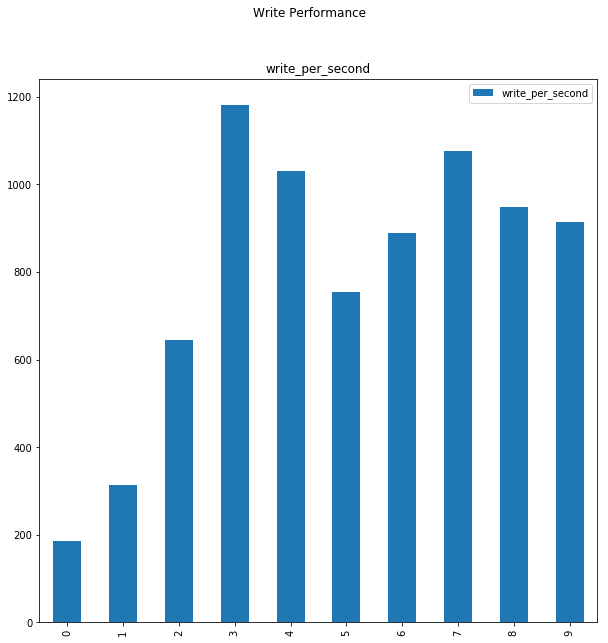

In [19]:
producer_df = pd.DataFrame.from_dict(write_readings, orient='index').rename(columns={0: 'write_per_second'})
producer_df.sort_index(inplace=True)
producer_df
producer_df.plot(kind='bar', subplots=True, figsize=(10, 10), title="Write Performance")